# Semi-supervised Learning Tutorial

## The tutorial will use the RSSL package (https://cran.r-project.org/web/packages/RSSL/RSSL.pdf), and illustrate the algorithm of self-training and semi-supervised SVM. More details about the package can be found at: https://arxiv.org/pdf/1612.07993.pdf

In [ ]:
#install.packages("RSSL")
#install.packages("dplyr")
#install.packages("tidyr")
#install.packages("ggplot2")
# he package "RSSL" can also be installed with the following command:
#library(devtools)
#install_github("jkrijthe/RSSL")

### Task 1: Self-training with Nearest Mean Classifier
In this task, the data comes from 2 class Gaussian distribution, we will show how to use self training to boost the performance of a Nearest Neighbour classifier. More details can be found at: https://cran.rstudio.com/web/packages/RSSL/readme/README.html

In [2]:
library(RSSL)
library(dplyr,warn.conflicts = FALSE)
library(ggplot2,warn.conflicts = FALSE)
library(tidyr)

First, we set a random seed and generate 200 data points from two classes, with the variance as 0.2. Second, we randomly remove some labels to get the simulated unlabeled set. Third, we do self training for the Nearest Mean Classifier. We will see the difference of the decision boundary after incorperating the unlabeled set. The detailed code of the module SelfLearning can be found at: https://rdrr.io/cran/RSSL/src/R/SelfLearning.R

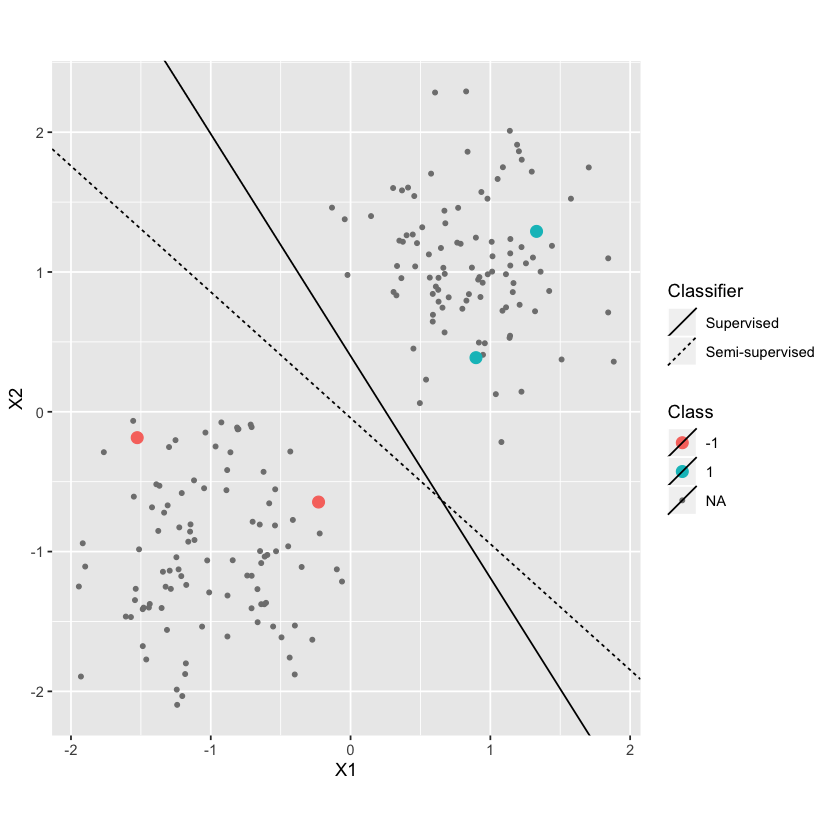

In [3]:
set.seed(2)
df <- generate2ClassGaussian(200, d=2, var = 0.2, expected=TRUE)

# Randomly remove labels
df <- df %>% add_missinglabels_mar(Class~.,prob=0.98) 

# Train classifier
g_nm <- NearestMeanClassifier(Class~.,df,prior=matrix(0.5,2))
g_self <- SelfLearning(Class~.,df,
                       method=NearestMeanClassifier,
                       prior=matrix(0.5,2))

# Plot dataset
df %>% 
  ggplot(aes(x=X1,y=X2,color=Class,size=Class)) +
  geom_point() +
  coord_equal() +
  scale_size_manual(values=c("-1"=3,"1"=3), na.value=1) +
  geom_linearclassifier("Supervised"=g_nm,
                  "Semi-supervised"=g_self)

We will get the squared loss of the two models (supervised v.s. semi-supervised).

In [4]:
# Evaluate performance: Squared Loss & Error Rate
mean(loss(g_nm,df))
mean(loss(g_self,df))


mean(predict(g_nm,df)!=df$Class)
mean(predict(g_self,df)!=df$Class)

[1] 11.6184

[1] 11.43662

[1] NA

[1] NA

The squared loss of the self trained classifier is smaller than that of supervised model. In other words, unlabeleld set helps.

### Task 2: Semi-supervised learning with SVM

The method (S4VM) randomly generates multiple low-density separators (controlled by the sample_time parameter) and merges their predictions by solving a linear programming problem meant to penalize the cost of decreasing the performance of the classifier, compared to the supervised SVM. S4VM is a bit of a misnomer, since it is a transductive method that only returns predicted labels for the unlabeled objects. The main difference in this implementation compared to the original implementation is the clustering of the low-density separators: in our implementation empty clusters are not dropped during the k-means procedure. In the paper by Li (2011) the features are first normalized to [0,1], which is not automatically done by this function. Note that the solution may not correspond to a linear classifier even if the linear kernel is used. More details can be found at: https://rdrr.io/cran/RSSL/man/S4VM.html



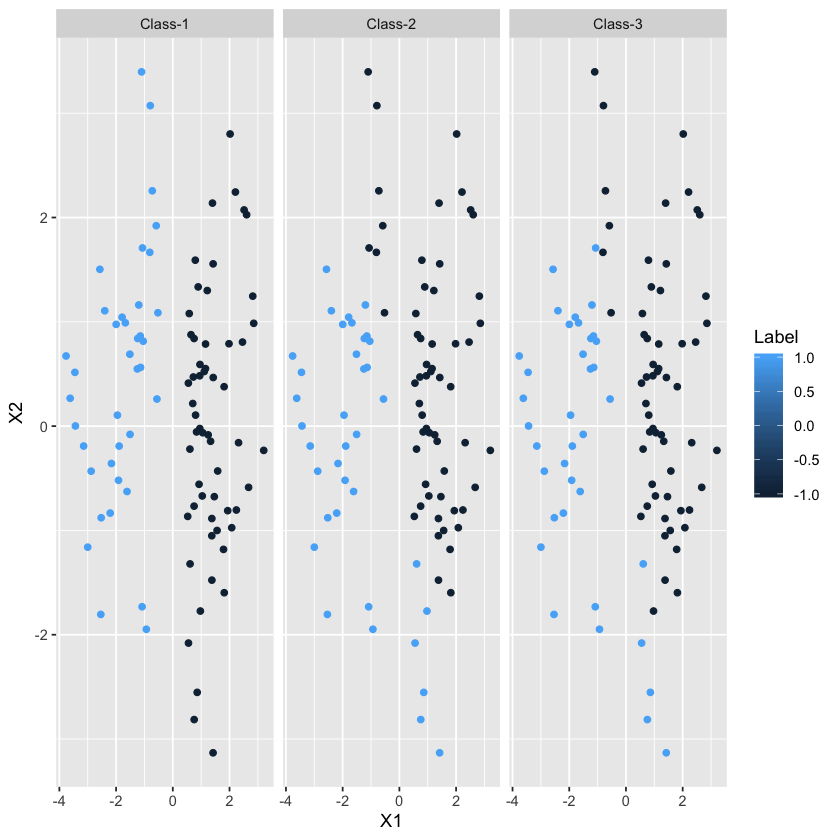

In [7]:
set.seed(1)
df_orig <- generateSlicedCookie(100,expected=TRUE)
df <- df_orig %>% add_missinglabels_mar(Class~.,0.95)
g_s <- SVM(Class~.,df,C=1,scale=TRUE,x_center=TRUE)
g_s4 <- S4VM(Class~.,df,C1=1,C2=0.1,lambda_tradeoff = 3,scale=TRUE,x_center=TRUE)

labs <- g_s4@labelings[-c(1:5),]
colnames(labs) <- paste("Class",seq_len(ncol(g_s4@labelings)),sep="-")

# Show the labelings that the algorithm is considering
df %>%
  filter(is.na(Class)) %>% 
  bind_cols(data.frame(labs,check.names = FALSE)) %>% 
  select(-Class) %>% 
  gather(Classifier,Label,-X1,-X2) %>% 
  ggplot(aes(x=X1,y=X2,color=Label)) +
  geom_point() +
  facet_wrap(~Classifier,ncol=5)





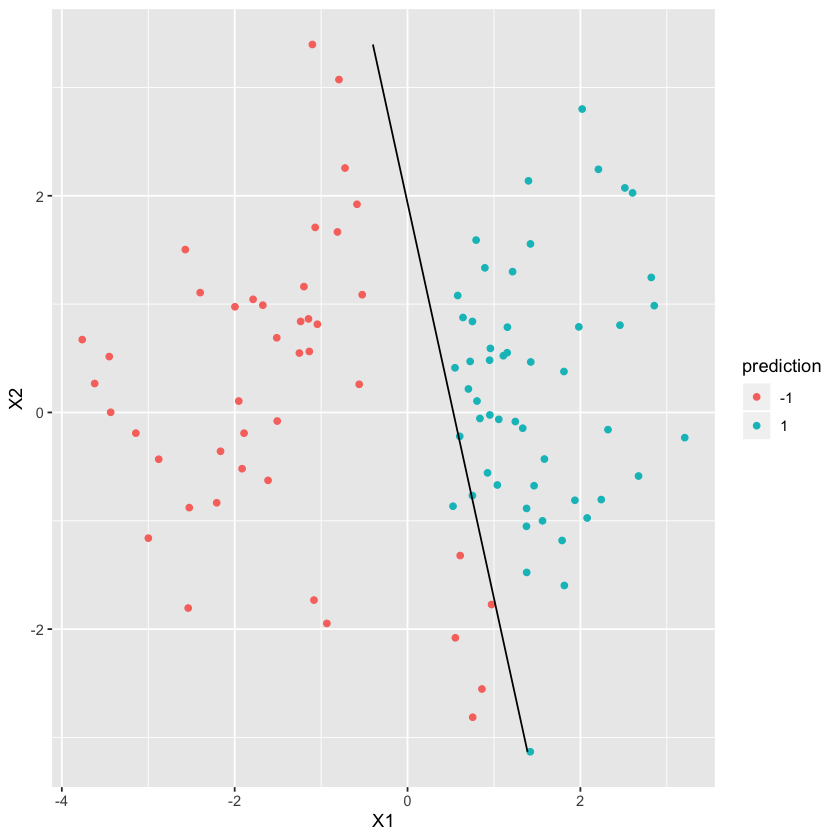

In [6]:
# Plot the final labeling that was selected
# Note that this may not correspond to a linear classifier
# even if the linear kernel is used.
# The solution does not seem to make a lot of sense,
# but this is what the current implementation returns
df %>% 
  filter(is.na(Class)) %>% 
  mutate(prediction=g_s4@predictions) %>% 
  ggplot(aes(x=X1,y=X2,color=prediction)) +
  geom_point() +
  stat_classifier(color="black", classifiers=list(g_s))

The detailed code of module S4VM can be found at: https://rdrr.io/cran/RSSL/src/R/S4VM.R

Some other useful materials, please also do these exercises by yourself.
### * Semi-supervised learning in sklearn https://scikit-learn.org/stable/modules/label_propagation.html#semi-supervised
### *Self training for image classification, with keras https://www.kaggle.com/glowingbazooka/semi-supervised-model-using-keras
### *Semi-supervised learning book https://www.molgen.mpg.de/3659531/MITPress--SemiSupervised-Learning.pdf